In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy.random as nr

import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn import preprocessing
import sklearn.metrics as sklm

%matplotlib inline

In [38]:
train_data = pd.read_csv('preped_data3.csv')
labels = np.array(train_data['accepted'])

In [39]:
train_data.drop('row_id', axis = 1, inplace = True)
train_data.drop('accepted', axis = 1, inplace = True)

In [40]:
# features_cols = [col for col in train_data.columns if train_data[col].dtype == int or train_data[col].dtype == float]

# 0.62 --> Accuracy
feature_cols = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'loan_amount', 'preapproval', 'msa_md', 'state_code', 
        'county_code', 'applicant_ethnicity','applicant_race', 'applicant_sex', 'applicant_income', 'population', 
        'minority_population_pct', 'ffiecmedian_family_income', 'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units', 
        'number_of_1_to_4_family_units', 'lender']

print(len(feature_cols))

features = np.array(train_data[feature_cols])
print(features.shape)

20
(387163, 20)


In [41]:
nr.seed(9988)
indx = range(features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [42]:
scaler = preprocessing.StandardScaler().fit(X_train[:,19:])
X_train[:,19:] = scaler.transform(X_train[:,19:])
X_test[:,19:] = scaler.transform(X_test[:,19:])

In [43]:
logistic_mod = linear_model.LogisticRegression() 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-0.00378809]
[[ 1.06036747e-02 -2.75039103e-02 -2.62611689e-01 -6.53760373e-03
   5.49674138e-04 -8.31396993e-02 -1.25556704e-04  3.76835507e-03
  -8.31753060e-05 -3.10735155e-02  8.78144244e-03 -5.24506767e-02
   5.57367124e-04  5.71816234e-05 -7.42946862e-03  4.90622091e-06
   7.38909158e-03 -3.51969639e-05 -1.39594594e-04  7.34251541e-03]]


In [45]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.41911288 0.58088712]
 [0.49251637 0.50748363]
 [0.60127205 0.39872795]
 [0.49429968 0.50570032]
 [0.49452511 0.50547489]
 [0.4747254  0.5252746 ]
 [0.48202427 0.51797573]
 [0.54079319 0.45920681]
 [0.46978792 0.53021208]
 [0.49647211 0.50352789]
 [0.48185859 0.51814141]
 [0.31599209 0.68400791]
 [0.6404743  0.3595257 ]
 [0.3652911  0.6347089 ]
 [0.55247883 0.44752117]]


In [46]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[1 1 0 1 1 1 1 0 1 1 1 1 0 1 0]
[1 0 1 1 1 1 0 0 0 1 0 1 0 0 1]


In [47]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive        66                64
Actual negative        51               119

Accuracy  0.62
 
           Positive      Negative
Num case      130           170
Precision    0.56          0.65
Recall       0.51          0.70
F1           0.53          0.67


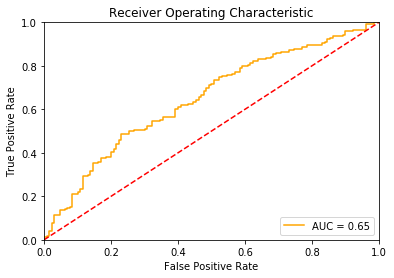

In [48]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)

In [49]:
# Using Supplied TEST VALUES to test for model accuracy 
test_values = pd.read_csv('test_values.csv')
test_values.shape

(500000, 22)

In [51]:
cols = ['state_code', 'county_code', 'msa_md']
for col in cols:
    test_values.loc[test_values[col] == -1, col] = np.nan

In [52]:
test_values.dropna(inplace=True)

In [54]:
test_values.shape

(386884, 22)

In [55]:
test_values.isnull().sum()

row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
msa_md                            0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_race                    0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
lender                            0
co_applicant                      0
dtype: int64

In [56]:
test_cols = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'loan_amount', 'preapproval', 'msa_md', 'state_code', 
        'county_code', 'applicant_ethnicity','applicant_race', 'applicant_sex', 'applicant_income', 'population', 
        'minority_population_pct', 'ffiecmedian_family_income', 'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units', 
        'number_of_1_to_4_family_units', 'lender']

features_test = np.array(test_values[test_cols])
print(features_test.shape)

(386884, 20)


In [57]:
features_test[:,19:] = scaler.transform(features_test[:,19:])

In [58]:
probabilities = logistic_mod.predict_proba(features_test)
print(probabilities[:15,:])

[[0.33971349 0.66028651]
 [0.41868531 0.58131469]
 [0.37603093 0.62396907]
 [0.53503015 0.46496985]
 [0.49352724 0.50647276]
 [0.37041045 0.62958955]
 [0.35209212 0.64790788]
 [0.37646327 0.62353673]
 [0.58563342 0.41436658]
 [0.51595942 0.48404058]
 [0.49476643 0.50523357]
 [0.41850894 0.58149106]
 [0.41861855 0.58138145]
 [0.396684   0.603316  ]
 [0.49703243 0.50296757]]


In [59]:
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))

[1 1 1 0 1 1 1 1 0 0 1 1 1 1 1]


In [61]:
initial_predict_submission = pd.DataFrame(data=test_values['row_id'], columns=['row_id'])
initial_predict_submission['accepted'] = scores

initial_predict_submission.shape

(386884, 2)

In [62]:
initial_predict_submission.head()

,row_id,accepted
1,1,1
3,3,1
4,4,1
5,5,0
7,7,1


In [63]:
initial_predict_submission.to_csv('initial_predict_submission-2.csv', index=None)